# 导库与函数

In [110]:
import modin.pandas as pd

import modin.config as cfg
cfg.StorageFormat.put('hdk')

import os

import warnings

warnings.filterwarnings("ignore")
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import config_context

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [126]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold,cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn import svm
#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
import time
#from joblib import dump,load
warnings.filterwarnings("ignore")

#plt.rcParams['font.family'] = 'SongTi SC'
plt.rcParams['axes.unicode_minus'] = False
# Set random seed
np.random.seed(42)

In [112]:
def paintting(f, t, auc):
    # 绘制 ROC 曲线
    plt.plot(f, t, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [113]:
def calculator_index(model,test_feature,test_target):
    y_pred = model.predict(test_feature)
    print(pd.DataFrame(confusion_matrix(test_target, y_pred), columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    #算指标
    probs_c = model.predict_proba(test_feature)
    fpr_c, tpr_c, thresholds_c = roc_curve(test_target, probs_c[:, 1])
    roc_auc_c = auc(fpr_c, tpr_c)
    
    print("accuracy:", accuracy_score(test_target, y_pred))
    print("precision:", precision_score(test_target, y_pred))
    print("recall:", recall_score(test_target, y_pred))
    print("roc_auc:", roc_auc_c)
    print("f1:", f1_score(test_target, y_pred))

    return y_pred, fpr_c, tpr_c, roc_auc_c



In [114]:
def grid(model, param,train_feature,train_target):
    #定义网格搜索优化的函数
    grid_search = GridSearchCV(model, param, cv = 3,
                            return_train_score = True,n_jobs = -1,
                               scoring = make_scorer(average_precision_score))
    grid_search.fit(train_feature, train_target)
    print(grid_search.best_params_)
    return grid_search

# 导入文件

In [115]:
df = pd.read_csv('creditcard.csv')

In [116]:
df = df.dropna()
df.drop_duplicates(inplace=True)

In [117]:
feature = df.iloc[:,1:-1]
target = df.iloc[:,-1]
feature_value = feature.values
target_value = target.values

In [118]:
train_feature, test_feature, train_target, test_target = train_test_split(feature_value, target_value, test_size = 0.3)


# 无采样

## 随机森林

In [173]:
param_grid1 = {
 'min_samples_split': [6,7],
 'n_estimators' : [100,150],
 'max_depth': [9, 10,13],
 'max_features': [4,6,8] 
}
end = time.time()

In [175]:
start = time.time()
rf_f1 = RandomForestClassifier(oob_score=True)
grid_rf_f1 = grid(rf_f1, param_grid1, train_feature, train_target)
end = time.time()
print('耗时:',end-start)

{'max_depth': 9, 'max_features': 6, 'min_samples_split': 6, 'n_estimators': 100}
耗时: 52.8349826335907


In [176]:
start = time.time()
p_rf_f1 = {'max_depth': 9, 'max_features': 6, 'min_samples_split': 6, 'n_estimators': 150}
best_rf_f1 = RandomForestClassifier(**p_rf_f1)
best_rf_f1.fit(train_feature, train_target)
end = time.time()
print('耗时:',end-start)

耗时: 0.8550999164581299


In [177]:
y_pred_clf_rf1, fpr_clf_rf1, tpr_clf_rf1, auc_clf_rf1 = calculator_index(best_rf_f1,test_feature,test_target)


     pred_neg  pred_pos
neg     34870         3
pos        15        56
accuracy: 0.9994848901098901
precision: 0.9491525423728814
recall: 0.7887323943661971
roc_auc: 0.9729057105804038
f1: 0.8615384615384616


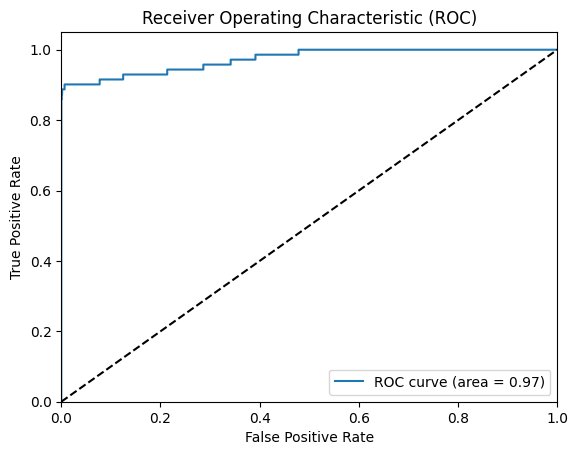

In [178]:
paintting(fpr_clf_rf1, tpr_clf_rf1, auc_clf_rf1)

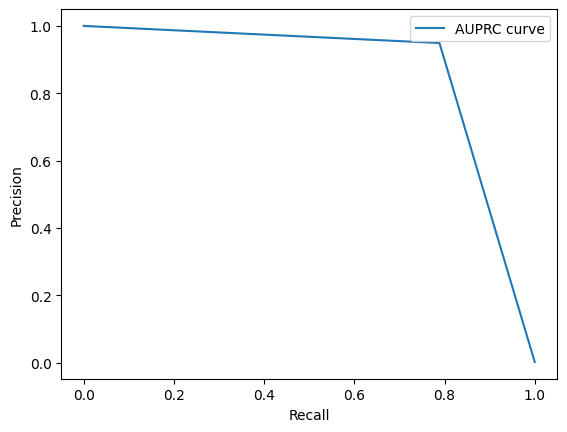

In [179]:
precision_rf1, recall_rf1, thresholds_rf1 = precision_recall_curve(test_target,best_rf_f1.predict(test_feature))
plt.plot(recall_rf1, precision_rf1, label='AUPRC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [180]:
auprc_rf1 = average_precision_score(test_target, best_rf_f1.predict(test_feature))
print('AUPRC:', auprc_rf1)

AUPRC: 0.7490566156062843


## XGBoost

In [154]:
param_grid_xgb = {
'colsample_bytree' : [0.8,1],
'gamma' : [0],
'learning_rate' : [0.1,0.2],
'max_depth' : [9,12],
'min_child_weight' : [3, 5],
'n_estimators' : [150,300],
'reg_alpha' : [0,0.1],
'subsample' : [0.8,1]
}

In [155]:
xgb_f1_1 = xgb.XGBClassifier(objective="binary:logistic", random_state = 42)
grid_xgb_f1_1 = grid(xgb_f1_1, param_grid_xgb, train_feature, train_target)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0, 'subsample': 0.8}
273.2611587047577


In [157]:
start = time.time()
clf_xgb1 = xgb.XGBClassifier(max_depth = 9,
                       learning_rate = 0.2,
                        n_estimators = 150,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       reg_alpha = 0,
                       reg_lambda = 0,
                       objective="binary:logistic")
clf_xgb1.fit(train_feature,train_target)
end = time.time()
print('耗时:',end-start)

耗时: 0.3765137195587158


In [149]:
y_pred_clf_xgb1, fpr_clf_xgb1, tpr_clf_xgb1, auc_clf_xgb1 = calculator_index(clf_xgb1,test_feature,test_target)


     pred_neg  pred_pos
neg     34870         3
pos        11        60
accuracy: 0.9995993589743589
precision: 0.9523809523809523
recall: 0.8450704225352113
roc_auc: 0.9707397021708145
f1: 0.8955223880597014


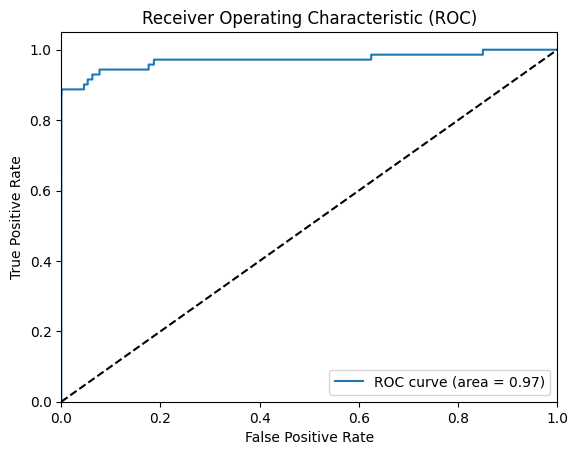

In [150]:
paintting(fpr_clf_xgb1, tpr_clf_xgb1, auc_clf_xgb1)

In [151]:
precision_xgb1, recall_xgb1, thresholds_xgb1 = precision_recall_curve(test_target,clf_xgb1.predict(test_feature))

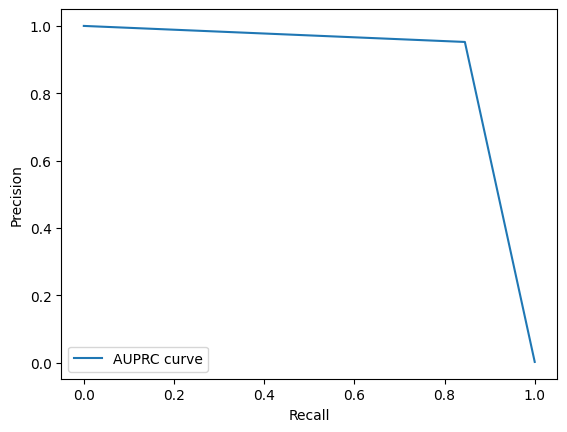

In [152]:
plt.plot(recall_xgb1, precision_xgb1, label='AUPRC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [153]:
auprc_xgb1 = average_precision_score(test_target, clf_xgb1.predict(test_feature))
print('AUPRC:', auprc_xgb1)

AUPRC: 0.8051437632203476


# 采样

In [28]:
over_sampler = SMOTE(sampling_strategy=0.01)  
under_sampler = RandomUnderSampler(sampling_strategy=0.01) 
pipeline = Pipeline([
    ('over_sampling', over_sampler),
    ('under_sampling', under_sampler)
])

x_resampled, y_resampled = pipeline.fit_resample(train_feature, train_target)

In [30]:
y_resampled.sum()

1990

In [31]:
len(y_resampled)

200990

## 随机森林

In [181]:
clf_rf2 = RandomForestClassifier(n_jobs = -1, random_state = 42,
                             max_depth = 9, max_features = 6, min_samples_split = 6, n_estimators = 150)
clf_rf2.fit(x_resampled, y_resampled)

RandomForestClassifier(max_depth=9, max_features=6, min_samples_split=6,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [182]:
y_pred_clf_rf2, fpr_clf_rf2, tpr_clf_rf2, auc_clf_rf2 = calculator_index(clf_rf2,test_feature,test_target)

     pred_neg  pred_pos
neg     34866         7
pos        10        61
accuracy: 0.9995135073260073
precision: 0.8970588235294118
recall: 0.8591549295774648
roc_auc: 0.9879171222096437
f1: 0.8776978417266187


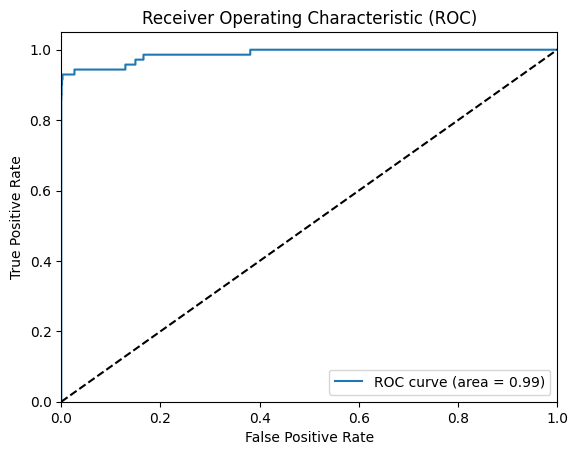

In [183]:
paintting(fpr_clf_rf2, tpr_clf_rf2, auc_clf_rf2)

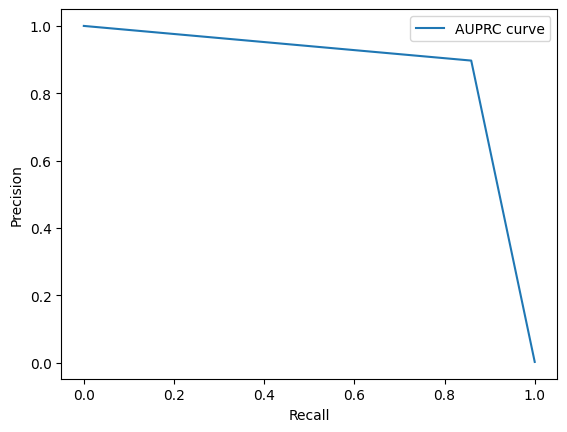

In [184]:
precision_rf2, recall_rf2, thresholds_rf2 = precision_recall_curve(test_target,clf_rf2.predict(test_feature))

plt.plot(recall_rf2, precision_rf2, label='AUPRC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [185]:
auprc_rf2 = average_precision_score(test_target, clf_rf2.predict(test_feature))
print('AUPRC:', auprc_rf2)

AUPRC: 0.7709986825174274


## XGBoost

In [142]:
clf_xgb2 = xgb.XGBClassifier(max_depth = 9,
                       learning_rate = 0.2,
                        n_estimators = 150,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       reg_alpha = 0,
                       reg_lambda = 0,
                       objective="binary:logistic")
clf_xgb2.fit(x_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [144]:
y_pred_clf_xgb2, fpr_clf_xgb2, tpr_clf_xgb2, auc_clf_xgb2 = calculator_index(clf_xgb2,test_feature,test_target)

     pred_neg  pred_pos
neg     34871         2
pos         3        68
accuracy: 0.9998569139194139
precision: 0.9714285714285714
recall: 0.9577464788732394
roc_auc: 0.9952976252260214
f1: 0.9645390070921985


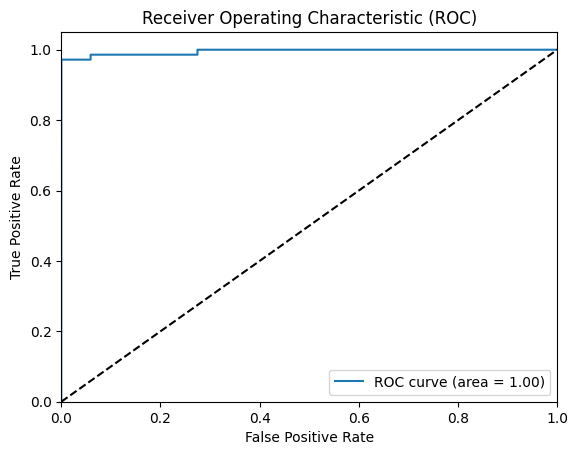

In [145]:
paintting(fpr_clf_xgb2, tpr_clf_xgb2, auc_clf_xgb2)

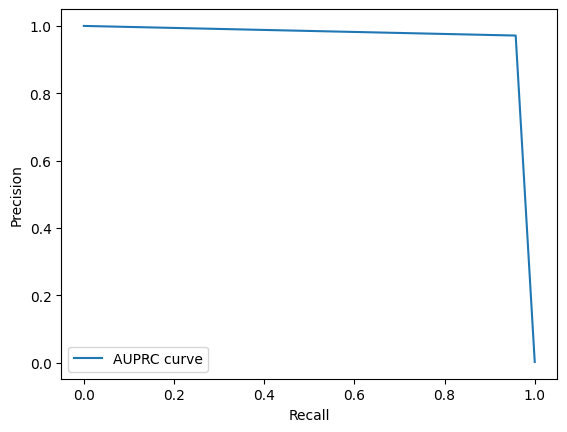

In [146]:
precision_xgb2, recall_xgb2, thresholds_xgb2 = precision_recall_curve(test_target,clf_xgb2.predict(test_feature))
plt.plot(recall_xgb2, precision_xgb2, label='AUPRC curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [147]:
auprc_xgb2 = average_precision_score(test_target, clf_xgb2.predict(test_feature))
print('AUPRC:', auprc_xgb2)

AUPRC: 0.930468145410927


# 曲线比较

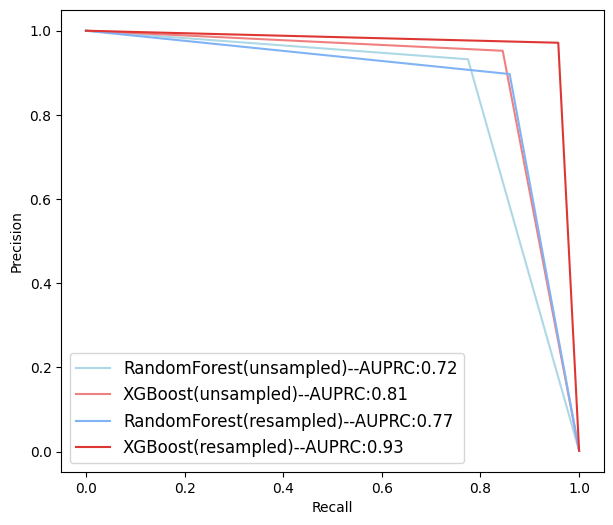

In [170]:
plt.figure(figsize = (7,6))
plt.plot(recall_rf1, precision_rf1, label=f'RandomForest(unsampled)--AUPRC:{round(auprc_rf1,2)}',color = 'lightblue')
plt.plot(recall_xgb1, precision_xgb1, label=f'XGBoost(unsampled)--AUPRC:{round(auprc_xgb1,2)}',color = 'lightcoral')
plt.plot(recall_rf2, precision_rf2, label=f'RandomForest(resampled)--AUPRC:{round(auprc_rf2,2)}',color = '#80B3F6')
plt.plot(recall_xgb2, precision_xgb2, label=f'XGBoost(resampled)--AUPRC:{round(auprc_xgb2,2)}',color = '#DE3633')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(prop={'size': 12})
plt.savefig('对比图.png')
plt.show()